# Card Classification via CLIP

In this notebook, we explored using CLIP to classify Pokémon cards to see if it's feasible for our Capstone project. We began by fetching Pokémon card images and creating embeddings for them with a pretrained CLIP model available through Huggingface. We observed that while we were able to get decently fast predictions and the ability to search for cards with text, the embeddings themselves were very large in size (about 10 GB with the whole dataset), making it infeasible for a mobile application. Further, an advantage of using CLIP over perceptual hashing was that it provided a way to do text-to-image search; however, from testing, it does not work that well, even after creating more meaningful labels for the images when making the embeddings. Therefore, we should consider using perceptual hashing as our main method of card classification.

With perceptual hashing, we should also explore using the small image sizes instead of the large ones. Or, using the large images, but resizing them. We can also explore a mix of perceptual hashing and deep learning as shown in [this paper](https://www.researchgate.net/publication/382197984_Perceptual_Hashing_Using_Pretrained_Vision_Transformers).

This notebook was run on Google Colab and downloaded for this repo.

## Download cards from json


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install -Uqq fastai faiss-cpu

In [3]:
# Currently loaded sets ~19600 cards in total
!ls gdrive/MyDrive/4ZP6/data/jsons

base1.json   ecard1.json  mcd18.json	 sm3.json	   swsh1.json
base2.json   ecard2.json  mcd19.json	 sm4.json	   swsh2.json
base3.json   ecard3.json  mcd21.json	 sm5.json	   swsh35.json
base4.json   ex10.json	  mcd22.json	 sm6.json	   swsh3.json
base5.json   ex11.json	  me1.json	 sm75.json	   swsh45.json
base6.json   ex12.json	  neo1.json	 sm7.json	   swsh45sv.json
basep.json   ex13.json	  neo2.json	 sm8.json	   swsh4.json
bp.json      ex14.json	  neo3.json	 sm9.json	   swsh5.json
bw10.json    ex15.json	  neo4.json	 sma.json	   swsh6.json
bw11.json    ex16.json	  np.json	 smp.json	   swsh7.json
bw1.json     ex1.json	  pgo.json	 sv10.json	   swsh8.json
bw2.json     ex2.json	  pl1.json	 sv1.json	   swsh9.json
bw3.json     ex3.json	  pl2.json	 sv2.json	   swsh9tg.json
bw4.json     ex4.json	  pl3.json	 sv3.json	   swshp.json
bw5.json     ex5.json	  pl4.json	 sv3pt5.json	   tk1a.json
bw6.json     ex6.json	  pop1.json	 sv4.json	   tk1b.json
bw7.json     ex7.json	  pop2.json	 sv4pt5.json	   tk2

In [4]:
from fastai.vision.all import *
from fastdownload import download_url

In [5]:
path = Path('gdrive/MyDrive/4ZP6/data/jsons')

In [6]:
pokemon_sets = os.listdir(path)
pokemon_sets[0:5], len(pokemon_sets)

(['swsh3.json', 'pop8.json', 'pl3.json', 'sm7.json', 'ecard2.json'], 169)

In [7]:
import json

For the sake of repeatability, we'll use a subset of the data. The whole data was used to come to the conclusion of looking into perceptual hashing. With using all cards, there's around 19600 cards, which when downloaded, the data itself is about 10gb and the resulting embeddings take up about 10gb when saved.

In [8]:
all_cards = []
for pokemon_set in ['base1.json', 'base2.json', 'base5.json']: # pokemon_sets:
    with open(path/pokemon_set, 'r') as file:
        cards = json.load(file)
        for card in cards:
            all_cards.append(card)

len(all_cards), all_cards[0]

(249,
 {'id': 'base1-1',
  'name': 'Alakazam',
  'supertype': 'Pokémon',
  'subtypes': ['Stage 2'],
  'level': '42',
  'hp': '80',
  'types': ['Psychic'],
  'evolvesFrom': 'Kadabra',
  'abilities': [{'name': 'Damage Swap',
    'text': "As often as you like during your turn (before your attack), you may move 1 damage counter from 1 of your Pokémon to another as long as you don't Knock Out that Pokémon. This power can't be used if Alakazam is Asleep, Confused, or Paralyzed.",
    'type': 'Pokémon Power'}],
  'attacks': [{'name': 'Confuse Ray',
    'cost': ['Psychic', 'Psychic', 'Psychic'],
    'convertedEnergyCost': 3,
    'damage': '30',
    'text': 'Flip a coin. If heads, the Defending Pokémon is now Confused.'}],
  'weaknesses': [{'type': 'Psychic', 'value': '×2'}],
  'retreatCost': ['Colorless', 'Colorless', 'Colorless'],
  'convertedRetreatCost': 3,
  'number': '1',
  'artist': 'Ken Sugimori',
  'rarity': 'Rare Holo',
  'flavorText': 'Its brain can outperform a supercomputer. Its in

In [9]:
def create_description(card):
    desc = f"{card.get('id')} A"
    if card.get('subtypes') is not None:
        desc += f" {' '.join(card.get('subtypes'))}"
    desc += f" {card.get('supertype')} Card"

    if card.get('types') is not None:
        desc += f" of type {' and '.join(card.get('types'))}"
    desc += f" with the title \"{card.get('name')}\""

    if card.get('hp') is not None:
        desc += f" and {card.get('hp')} HP"

    if card.get('rarity') is not None:
        desc += f" of rarity {card.get('rarity')}"

    if card.get('evolvesFrom') is not None:
        desc += f" evolved from {card.get('evolvesFrom')}"

    if card.get('set') is not None:
        desc += f" from the set {card.get('set')}"

    if card.get('flavorText') is not None:
        desc += f" with the flavor text \"{card.get('flavorText')}\""

    if card.get('attacks') is not None:
        for attack in card.get('attacks'):
            desc += f". It has the attack \"{attack.get('name')}\" with the cost {', '.join(attack.get('cost'))}, the energy cost {attack.get('convertedEnergyCost')} with damage {attack.get('damage')} and the description: \"{attack.get('text')}\""

    if card.get('abilities') is not None:
        for ability in card.get('abilities'):
            desc += f". It has the ability \"{ability.get('name')}\" with the description: \"{ability.get('text')}\""

    if card.get('weaknesses') is not None:
        for weakness in card.get('weaknesses'):
            desc += f". Weak to {weakness.get('type')} {weakness.get('value')}"

    if card.get('resistances') is not None:
        for resistance in card.get('resistances'):
            desc += f". Resistant to {resistance.get('type')} {resistance.get('value')}"

    if card.get('rules') is not None:
        for rule in card.get('rules'):
            desc += f". It has the rule \"{rule}\""

    desc += '.'

    return desc

In [10]:
id_to_url = {}
id_to_description = {}
for card in all_cards:
    id_to_url[card['id']] = card['images']['large']
    id_to_description[card['id']] = create_description(card)

In [11]:
def download_imgs_inner(dest, inp):
    name,url = inp
    url = url.split("?")[0]
    url_path = Path(url)
    suffix = url_path.suffix if url_path.suffix else '.jpg'
    try: download_url(url, dest/f"{name}{suffix}", show_progress=False, timeout=4)
    except Exception as e: f"Couldn't download {url}."

def download_imgs(dest, obj=None):
    "Download images listed in `obj` ({ name: url }) to path `dest`"
    if obj is None:
        raise 'No images to download'
    dest = Path(dest)
    dest.mkdir(exist_ok=True)
    parallel(partial(download_imgs_inner, dest), obj.items(), n_workers=8, threadpool=True)

In [12]:
dest = Path('pokemon')

In [13]:
download_imgs(dest, obj=id_to_url)

In [14]:
fns = get_image_files(dest)
fns

(#249) [Path('pokemon/base5-74.png'),Path('pokemon/base5-17.png'),Path('pokemon/base5-2.png'),Path('pokemon/base1-81.png'),Path('pokemon/base1-38.png'),Path('pokemon/base2-39.png'),Path('pokemon/base1-57.png'),Path('pokemon/base1-71.png'),Path('pokemon/base1-70.png'),Path('pokemon/base1-18.png'),Path('pokemon/base1-77.png'),Path('pokemon/base2-59.png'),Path('pokemon/base2-33.png'),Path('pokemon/base5-80.png'),Path('pokemon/base2-4.png'),Path('pokemon/base5-32.png'),Path('pokemon/base5-50.png'),Path('pokemon/base1-74.png'),Path('pokemon/base1-3.png'),Path('pokemon/base5-28.png')...]

In [15]:
failed = verify_images(fns)
failed

(#0) []

In [16]:
failed.map(Path.unlink);

In [17]:
from datasets import Features, Image, Value, Dataset

In [18]:
data = []
for fn in get_image_files(dest):
    id = os.path.splitext(fn)[0].split('/')[-1]
    data.append({
        'image': fn.as_posix(),
        'text': id_to_description[id]
    })

features = Features({
    'image': Image(),
    'text': Value('string')
})

dataset = Dataset.from_list(data, features=features)
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 249
})

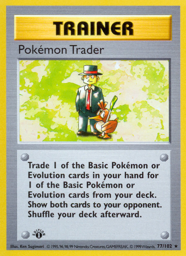

In [19]:
dataset[10]['image'].to_thumb(256)

In [20]:
dataset[10]['text']

'base1-77 A Trainer Card with the title "Pokémon Trader" of rarity Rare. It has the rule "Trade 1 of the Basic Pokémon or Evolution cards in your hand for 1 of the Basic Pokémon or Evolution cards from your deck. Show both cards to your opponent. Shuffle your deck afterward.".'

# Create embeddings for each images

In [21]:
import torch
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

device = 'cuda' if torch.cuda.is_available() else 'cpu'
pretrained_model = 'openai/clip-vit-base-patch32'

if device == 'cuda':
    torch.cuda.empty_cache()

processor = AutoProcessor.from_pretrained(pretrained_model)
model = AutoModelForZeroShotImageClassification.from_pretrained(pretrained_model, device_map=device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [22]:
def embed(batch):
    pixel_values = processor(images=batch['image'], return_tensors='pt')['pixel_values']
    pixel_values = pixel_values.to(device)
    img_emb = model.get_image_features(pixel_values)
    batch['embeddings'] = img_emb
    return batch

In [23]:
embedded_dataset = dataset.map(embed, batched=True, batch_size=32)

Map:   0%|          | 0/249 [00:00<?, ? examples/s]

In [24]:
embedded_dataset.save_to_disk('gdrive/MyDrive/4ZP6/data/embeds')

Saving the dataset (0/1 shards):   0%|          | 0/249 [00:00<?, ? examples/s]

In [25]:
from datasets import load_from_disk
embedded_dataset = load_from_disk('gdrive/MyDrive/4ZP6/data/embeds')

In [26]:
indexed_dataset = embedded_dataset.add_faiss_index('embeddings')

  0%|          | 0/1 [00:00<?, ?it/s]

# Create function to search image-to-image

In [27]:
dataset = indexed_dataset

In [28]:
import numpy as np

In [29]:
def search_i2i(query: str, k=4):
    "Embeds a new image `query` and returns the most `k` probable results"

    pixel_values = processor(images=query, return_tensors='pt')['pixel_values']
    pixel_values = pixel_values.to(device)

    # Because it's a single element
    img_emb = model.get_image_features(pixel_values)[0]

    # Convert to numpy because the Datasets library doesn't support torch vectors
    img_emb = img_emb.cpu().detach().numpy()

    scores, retrieved_examples = dataset.get_nearest_examples('embeddings', img_emb, k=k)

    return retrieved_examples

In [30]:
import matplotlib.pyplot as plt

In [31]:
from fastai.vision.all import Image

In [32]:
def test_model_i2i(name='chansey', k=4):
    im = Image.open(f'gdrive/MyDrive/4ZP6/data/test/{name}.png')
    retrieved_examples = search_i2i(im, k=k)
    f, ax = plt.subplots(1, k, figsize=(5, 2*k))
    for i in range(k):
        ax[i].set_title(retrieved_examples['text'][i].split(' ')[0])
        ax[i].imshow(retrieved_examples['image'][i])
        ax[i].axis('off')

    plt.show()

chansey:


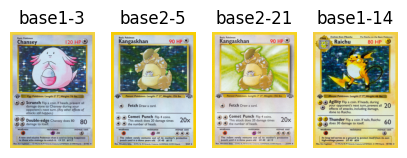

charizard:


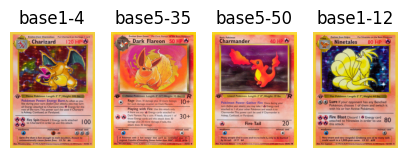

breeder:


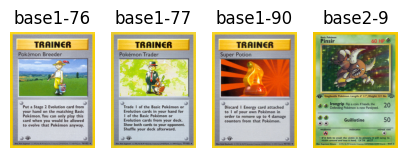

mewtwo:


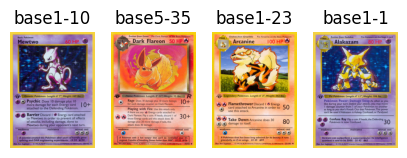

In [33]:
for pokemon in ['chansey', 'charizard', 'breeder', 'mewtwo']:
    print(f'{pokemon}:')
    test_model_i2i(pokemon)

# Create function to search text-to-image

In [34]:
def search_t2i(query: str, k=4):
    "Embeds a new image `query` and returns the most `k` probable results"

    tokens = processor(text=query, padding=True, return_tensors='pt')
    tokens = tokens.to(device)
    text_emb = model.get_text_features(**tokens)

    # Convert to numpy because the Datasets library doesn't support torch vectors
    text_emb = text_emb.cpu().detach().numpy()

    scores, retrieved_examples = dataset.get_nearest_examples('embeddings', text_emb, k=k)

    return retrieved_examples

In [35]:
def test_model_t2i(query='charizard', k=4):
    retrieved_examples = search_t2i(query, k=k)
    f, ax = plt.subplots(1, k, figsize=(2*k, 5))
    for i in range(k):
        ax[i].set_title(retrieved_examples['text'][i].split(' ')[0])
        ax[i].imshow(retrieved_examples['image'][i])
        ax[i].axis('off')

    plt.show()

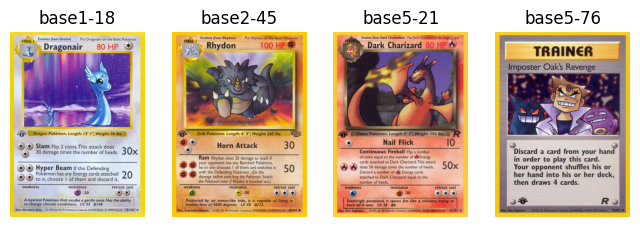

In [36]:
test_model_t2i('dark charizard', k=4)

# References

- [Image-based search engine](https://huggingface.co/blog/not-lain/image-retriever)
    - Walk-through on how to create an image-based search engine.
- [Pokémon TCG Data](https://github.com/PokemonTCG/pokemon-tcg-data/tree/master)
    - For the json files containing Pokémon card information and links to their images.